In [1]:
from IPython.display import Image
from community_simulator import *
from community_simulator.usertools import *
from community_simulator.visualization import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends import backend_pdf as bpdf
colors = sns.color_palette()
%matplotlib inline

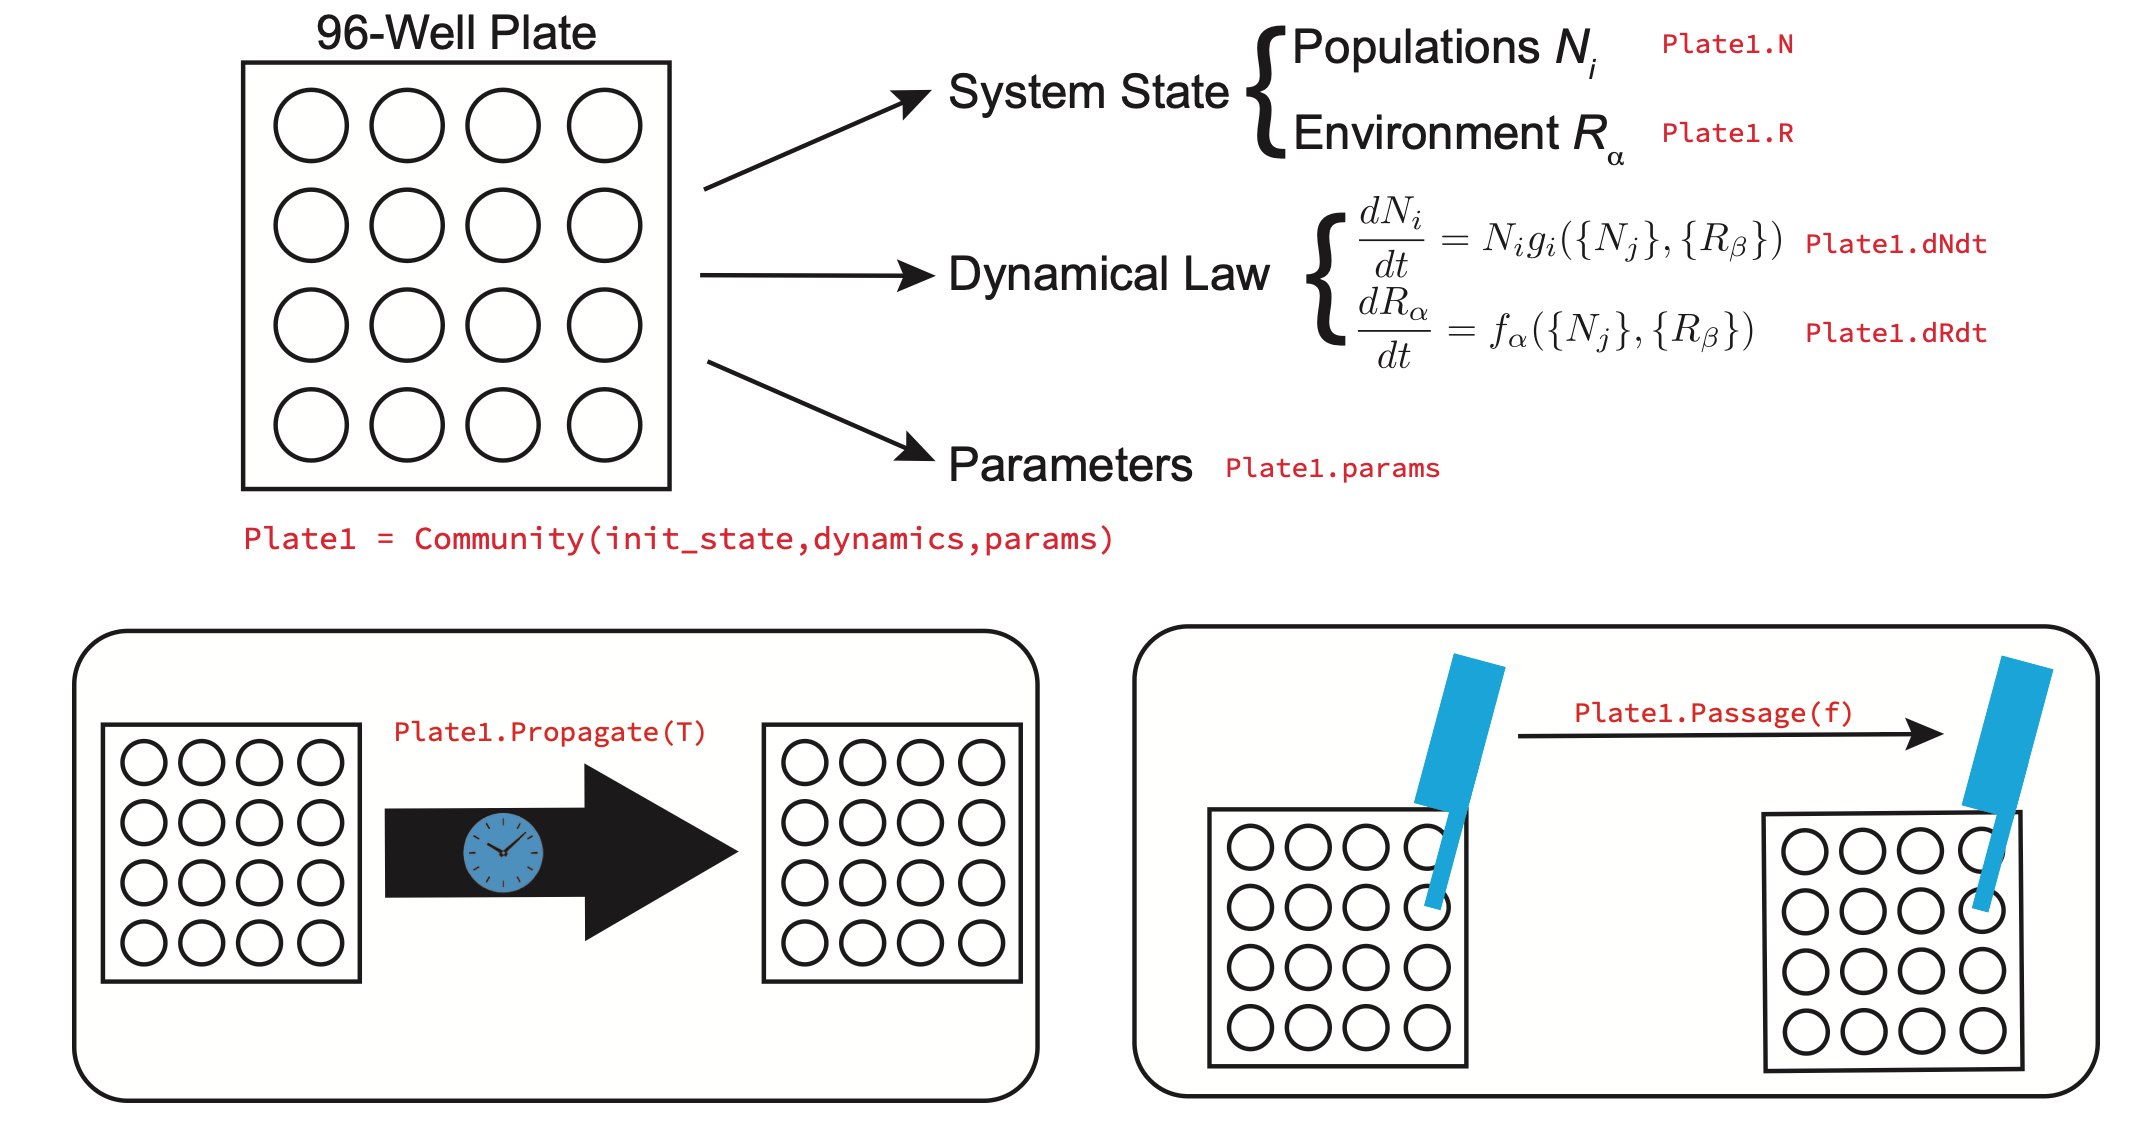

In [2]:
Image("schematic.png")

As illustrated in the figure above, Community Simulator is designed to run dynamics on multiple communities in parallel, inspired by the parallel experiments commonly performed with 96-well plates. The package contains six main features, organized around a Python class called `Community` whose instances represent these plates. Each section of this notebook describes one of these six features. Here is a brief summary of all of them:

- `MakeInitialState(assumptions)` performs a simple stochastic colonization protocol to generate a data frame of initial population sizes for all wells, by subsampling from a single regional pool. It also returns a data frame of initial resource concentrations, with one resource type supplied per well. 
- `MakeConsumerDynamics(assumptions)` and `MakeResourceDyanmics(assumptions)` construct dynamical equations using the Microbial Consumer Resource Model and a dictionary of modeling assumptions.
- `MakeMatrices(assumptions)` randomly samples the key parameter arrays of the model, whicha re the consumer matrix $c_{i\alpha}$ and the metabolic matrix $D_{\alpha\beta}$. `MakeParams(assumptions)` also assigns values to all the other model parameters, in order to generate a complete dictionary of parameters ready to feed to a new `Community` instance.
- `Community.Propagate(T)` sends each well to a separate CPU (for however many CPU's are available), runs the given population dynamics for a time $T$ using the SciPy function `odeint`, and updates the population sizes and resource concentrations in each well to the time-evolved values.
- `Community.Passage(f)` initializes a fresh set of wells by adding a fraction $f_{\mu\nu}$ of the contents of each old well $\nu$ to each new well $\mu$. The resulting values of $N_i$ are converted from arbitrary concentration units to actual population sizes using a specified scale factor, and then integer population sizes are obtained by multinomial sampling based on these values. 
- `Community.SteadyState()` finds the steady state of the dynamics, using a new algorithm based on convex optimization and expectation-maximization.

Before getting into the details, here is one brief example that illustrates most of the features. We'll use the model with default parameters, turn on crossfeeding, and supply different constant flux levels of a single externally supplied resource type to each well. Then we'll get the steady state and look at diversity. For more details on the setup, see Figure 1 of [Marsland <i>et al</i> PLoS Comp Biol. (2019)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006793). The basic setup is the same, except that we are using only one leakage level, and take only one sample per resource supply level. 

Note that the steady state algorithm does not set the population sizes of extinct species to exactly zero, leading to a bimodal distribution of population sizes. The lower mode should be extinct, so we will eliminate it by assigning a threshold between the two modes.

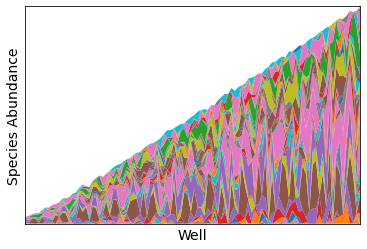

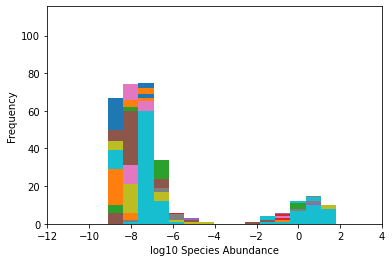

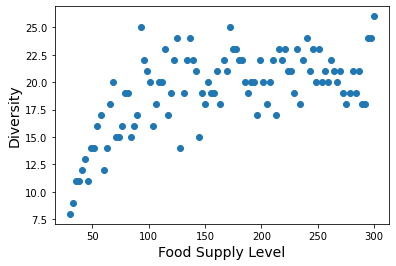

In [3]:
assumptions=a_default.copy() #Start with default parameters
assumptions['n_wells'] = 100 #Add more wells
assumptions['l'] = 0.8 #Assign a high leakage fraction to allow for a lot of crossfeeding
R0_food = np.linspace(30,300,assumptions['n_wells']) #Make a gradient of food supply levels
assumptions['R0_food'] = R0_food

#Make initial state
init_state = MakeInitialState(assumptions)

#Make dynamics
def dNdt(N,R,params):
    return MakeConsumerDynamics(assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

#Make parameters
params = MakeParams(assumptions)

#Initialize plate
#(parallel=False ensures that tutorial will run on Windows.
#If you are running on Mac or Linux, set parallel=True to speed up)
plate1 = Community(init_state,dynamics,params,parallel=True)

#Find steady state
plate1.SteadyState()

#Plot community compositions
fig,ax=plt.subplots()
StackPlot(plate1.N,ax=ax)
ax.set_xlabel('Well',fontsize=14)
ax.set_ylabel('Species Abundance',fontsize=14)
plt.show()

#Make histogram of all population sizes
fig,ax=plt.subplots()
np.log10(plate1.N+1e-20).plot.hist(ax=ax,bins=30,legend=False)
ax.set_xlim((-12,4))
ax.set_xlabel('log10 Species Abundance')
plt.show()

#Plot diversity
fig,ax=plt.subplots()
ax.scatter(R0_food,(plate1.N>1e-4).sum().values)
ax.set_xlabel('Food Supply Level',fontsize=14)
ax.set_ylabel('Diversity',fontsize=14)
plt.show()

# Modeling Assumptions

If you are using the built-in Microbial Consumer Resource Model (as opposed to your own custom dynamics -- see below for that), the initial state, dynamical law and parameters are generated based on a dictionary of modeling assumptions. The following is a list of the default values, contained in the dictionary `a_default` that we imported at the beginning. The comments describe what each one means: 

In [3]:
a_default = {'sampling':'Binary', #{'Gaussian','Binary','Gamma'} specifies choice of sampling algorithm
          'SA': 60*np.ones(3), #Number of species in each specialist family (here, 3 families of 60 species)
          'MA': 30*np.ones(3), #Number of resources in each class 
          'Sgen': 30, #Number of generalist species (unbiased sampling over alll resource classes)
          'muc': 10, #Mean sum of consumption rates (used in all models)
          'sigc': 3, #Standard deviation of sum of consumption rates for Gaussian and Gamma models
          'q': 0.0, #Preference strength of specialist families (0 for generalist and 1 for specialist)
          'c0':0.0, #Sum of background consumption rates in binary model
          'c1':1., #Specific consumption rate in binary model
          'l':0.8, #Leakage fraction
          'fs':0.45, #Fraction of secretion flux with same resource type
          'fw':0.45, #Fraction of secretion flux to 'waste' resource
          'sparsity':0.2, #Effective sparsity of metabolic matrix (between 0 and 1)
          'n_wells':10, #Number of independent wells
          'S':100, #Number of species per well (randomly sampled from the pool of size Stot = sum(SA) + Sgen)
          'food':0, #index of food source (when a single resource is supplied externally)
          'R0_food':1000, #unperturbed fixed point for supplied food
          'regulation':'independent', #metabolic regulation (see dRdt)
          'response':'type I', #functional response (see dRdt)
          'supply':'off' #resource supply (see dRdt)
         }

# Initial State

When running a batch culture simulation (see "Passaging" below), the composition of the "fresh media" supplied at each dilution step is given by R0. If you are supplying more than one resource type externally, R0 should be edited by hand before initializing your `Community` instance.

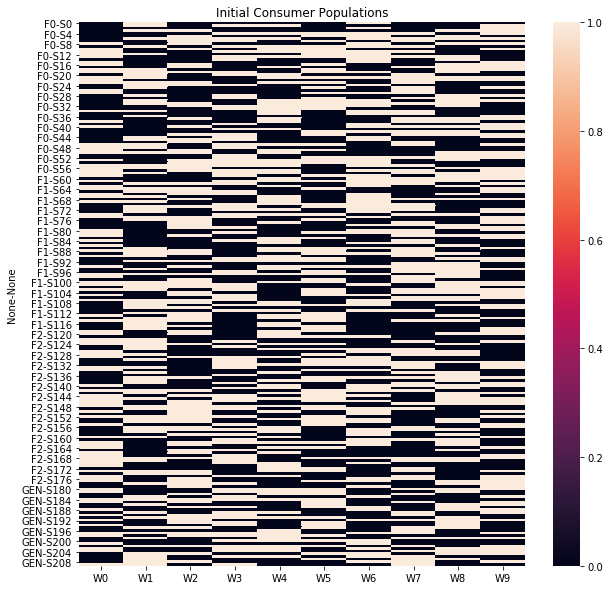

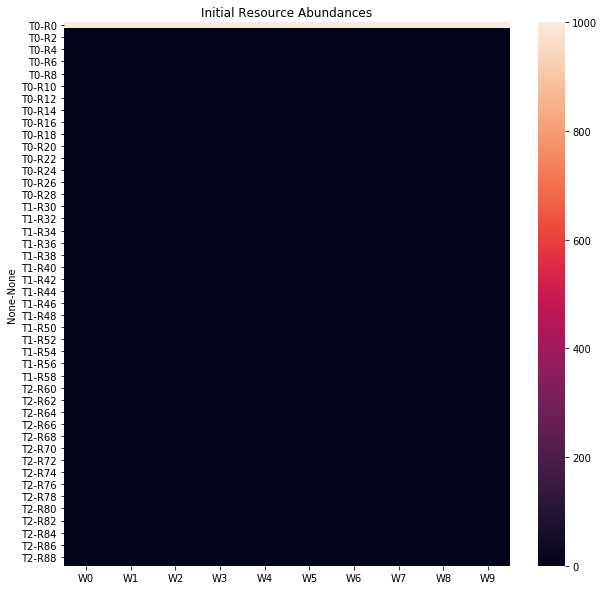

In [4]:
#Make initial state
N0,R0 = MakeInitialState(a_default)

fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(N0,ax=ax)
ax.set_title('Initial Consumer Populations')
plt.show()

fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(R0,ax=ax)
ax.set_title('Initial Resource Abundances')
plt.show()

# Dynamics

## Resource Supply

Here we plot the net resource supply rate as a function of resource concentration for the two possible assumptions about resource supply:

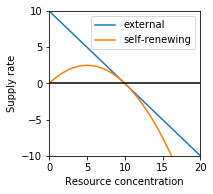

In [5]:
assumptions = a_default.copy()

#Resource vector
nR = 1000
Rvec = np.linspace(0,20,nR)

#Params to make plot of supply rate vs. R
#(each data point is a different 'species')
params = {'c':np.eye(nR),
          'w':1,
          'l':0,
          'D':np.eye(nR),
          'tau':1,
          'r':1/10,
          'R0':10}

#Set up plots
fig,ax = plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.2,bottom=0.21)

for supply in ['external','self-renewing']:
    assumptions['supply'] = supply
    
    #Make dynamics
    def dRdt(N,R,params):
        return MakeResourceDynamics(assumptions)(N,R,params)
    
    #Plot dRdt as function of R, with N = 0
    ax.plot(Rvec,dRdt(np.zeros(nR),Rvec,params),label=supply)
    
#Format Plots
ax.set_ylim((-10,10))
ax.set_xlim((0,20))
ax.plot([0,20],[0,0],'k')
plt.legend()
ax.set_xlabel('Resource concentration')
ax.set_ylabel('Supply rate')

#Save plots
#pdf = bpdf.PdfPages('supply.pdf')
#pdf.savefig(fig)
#pdf.close()
plt.show()

## Functional Response

Here we generate consumer dynamics for each of the three types of functional response (I, II and III) and plot the growth rate as a function of resource supply (for a single resource).

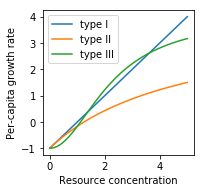

In [6]:
assumptions = a_default.copy()

#Resource vector
nR = 1000
Rvec = np.linspace(0,5,100)

#Params to make plot of supply rate vs. R
#(each data point is a different 'species')
params_plot = {'c':np.eye(100),
              'm':1,
              'g':1,
              'w':1,
              'D':np.eye(100),
              'l':0,
              'sigma_max':5,
              'n':2}

#Set up plots
fig,ax = plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.2,bottom=0.21)

for response in ['type I','type II','type III']:
    assumptions['response'] = response
    
    #Make dynamics
    def dNdt(N,R,params):
        return MakeConsumerDynamics(assumptions)(N,R,params)

    ax.plot(Rvec,dNdt(np.ones(100),Rvec,params_plot),label=response)

#Format plots    
plt.legend()
ax.set_xlabel('Resource concentration')
ax.set_ylabel('Per-capita growth rate')
#Save plots
#pdf = bpdf.PdfPages('response.pdf')
#pdf.savefig(fig)
#pdf.close()
plt.show()

## Regulation

The MicroCRM also has an option for implementing metabolic regulation, whereby an organism preferentially consumes more abundant resources. Abundance is measured in terms of the potential uptake rate in the absence of regulation, which can be measured in units of energy or of mass (which are the same if $w_\alpha = 1$).

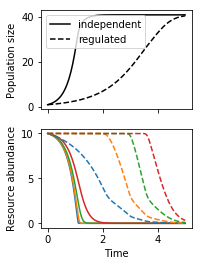

In [7]:
#Make assumptions for metabolic regulation (diauxic shift) and independent consumption
assumptions_diaux = {
              'regulation':'energy',
              'supply':'off',
              'response':'type II'
             }

assumptions_ind = {
              'regulation':'independent',
              'supply':'off',
              'response':'type II'
             }

#Construct dynamics for regulation
def dNdt1(N,R,params):
    return MakeConsumerDynamics(assumptions_diaux)(N,R,params)
def dRdt1(N,R,params):
    return MakeResourceDynamics(assumptions_diaux)(N,R,params)
dynamics_diaux = [dNdt1,dRdt1]

#Construct independent dynamics dynamics
def dNdt2(N,R,params):
    return MakeConsumerDynamics(assumptions_ind)(N,R,params)
def dRdt2(N,R,params):
    return MakeResourceDynamics(assumptions_ind)(N,R,params)
dynamics = [dNdt2,dRdt2]


#Construct consumer matrix with exponentially distributed preferences
M = 4
c = np.exp(np.linspace(np.log(5),-2,M))
c = c[np.newaxis,:]

#Make initial state
N0 = np.asarray([1])
R0 = np.ones(M)*10
init_state = [N0,R0]

#Make parameter list
params = {'c':c,
        'm':0,
        'w':1,
        'g':1,
        'R0':R0,
        'tau':1,
        'sigma_max':1,
        'nreg':10
       }


#Set up plots
fig,axs=plt.subplots(2,figsize=(3,4),sharex=True)
fig.subplots_adjust(left=0.2)

#Make plates
#(parallel=False ensures that tutorial will run on Windows.)
diauxic = Community(init_state,dynamics_diaux,params,parallel=False)
independent = Community(init_state,dynamics,params,parallel=False)

#Simulate and plot
t,N,R = independent.TestWell(T=5,ns=1000,show_plots=False)
axs[0].plot(t,N,'k',label='independent')
for k in range(len(R.T)):
    axs[1].plot(t,R[:,k],color=colors[k])
t,N,R = diauxic.TestWell(T=5,ns=1000,show_plots=False)
axs[0].plot(t,N,'k--',label='regulated')
for k in range(len(R.T)):
    axs[1].plot(t,R[:,k],'--',color=colors[k])
    
#Format plots
axs[0].legend()
axs[0].set_ylabel('Population size')
axs[1].set_ylabel('Resource abundance')
axs[1].set_xlabel('Time')

#Save plots
#pdf = bpdf.PdfPages('regulation.pdf')
#pdf.savefig(fig)
#pdf.close()
plt.show()

# Parameter Sampling

The MicroCRM requires the following dictionary of parameters in order to run:

`params = {'c':c, #consumer preference matrix c_ialpha
          'D':D, #metabolic matrix D_alphabeta
          'm':1, #vector of maintenance costs m_i (or scalar if they are all the same)
          'w':1, #vector of energy densities w_alpha (or scalar if they are all the same)
          'g':1, #vector of conversion factors g_i from energy to growth rate (or scalar if they are all the same)
          'l':0, #vector of leakage fractions l_alpha (or scalar if they are all the same)
          'R0':R0, #equilibrium of intrinsic resource dynamics (in absence of consumers)
          'tau':1, #turnover rate for externally supplied resources
          'r':1, #rate of self-renewal for self-renewing resources
          'n':2, #Hill coefficient for Type III functional response
          'sigma_max':1, #maximum uptake rate per resource
          'nreg':10 #Hill coefficient for metabolic regulation
           } `

where the last five in the list are only necessary under certain modeling assumptions, as stated in the comments. The Community Simulator includes a function `MakeMatrices` for automatically generating the two large matrices $c_{i\alpha}$ and $D_{\alpha\beta}$ based on the dictionary of modeling assumptions provided above. The function `MakeParams` calls `MakeMatrices` and then supplies all the other parameters with the default values listed above. Any of these parameters can be altered from the default by simply specifying it in the dictionary of assumptions (the Propagation section gives and example of this).

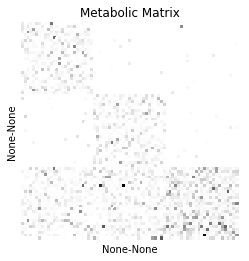

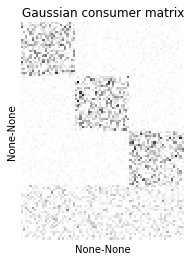

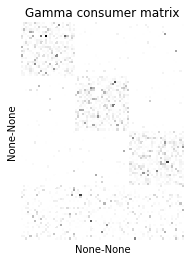

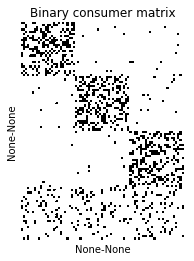

In [8]:
#Specify assumptions
a = {'sampling':'Gaussian',
     'SA': 25*np.ones(3),
     'MA': 25*np.ones(3), #Number of resources of each type
     'Sgen': 25, #Number of generalist species
     'muc': 10, #Mean sum of consumption rates
     'q': 0.9, #Preference strength (0 for generalist and 1 for specialist)
     'c0':0.0, #Background consumption rate in binary model
     'c1':1., #Specific consumption rate in binary model
     'fs':0.49, #Fraction of secretion flux with same resource type
     'fw':0.49, #Fraction of secretion flux to 'waste' resource
     'sparsity':0.05, #Variability in secretion fluxes among resources (must be less than 1)   
     }

#Calculate sigc to match binary
p = a['muc']/np.sum(a['MA'])
var = a['c1']**2 * p * (1-p)
a['sigc'] = np.sqrt(var*np.sum(a['MA']))

#Make matrices
c, D = MakeMatrices(a)

#Plot D matrix
fig,ax=plt.subplots()
sns.heatmap(D,cmap='Greys',vmin=0,square=True,xticklabels=False,yticklabels=False,cbar=False,ax=ax)
ax.set_title('Metabolic Matrix')
#pdf = bpdf.PdfPages('D.pdf')
#pdf.savefig(fig)
#pdf.close()
plt.show()

#Plot consumer matrix
for sampling in ['Gaussian','Gamma','Binary']:
    a['sampling'] = sampling
    c, D = MakeMatrices(a)
    fig,ax=plt.subplots()
    sns.heatmap(c,cmap='Greys',vmin=0,square=True,xticklabels=False,yticklabels=False,cbar=False,ax=ax)
    ax.set_title(sampling+' consumer matrix')
    #pdf = bpdf.PdfPages(sampling+'.pdf')
    #pdf.savefig(fig)
    #pdf.close()
    plt.show()

# Propagation

For this example, we will turn on the external supply (`'supply':'external'`) and set the leakage fraction to 0.8 (`'l':0.8`).

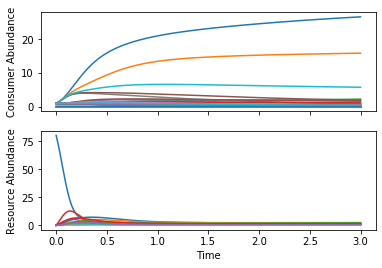

In [5]:
assumptions = a_default.copy()
assumptions.update({'SA':20*np.ones(3),
                    'MA':5*np.ones(3),
                    'Sgen':1,
                    'muc':2,
                    'R0_food':80,
                    'n_wells':100,
                    'food':0,
                    'S':40,
                    'l':0.8,
                    'supply':'external'})

init_state = MakeInitialState(assumptions)
params = MakeParams(assumptions)
def dNdt(N,R,params):
    return MakeConsumerDynamics(assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

#(parallel=False ensures that tutorial will run on Windows.
#If you are running on Mac or Linux, set parallel=True to speed up)
MyPlate = Community(init_state,dynamics,params,parallel=False)
t, Ntraj, Rtraj = MyPlate.TestWell(T=3,ns=5000)

Now we will iteratively propagate and plot the updated resource and consumer abundances:

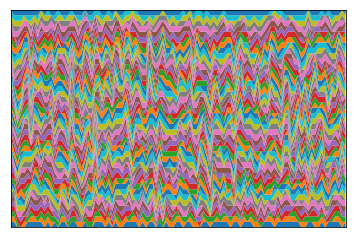

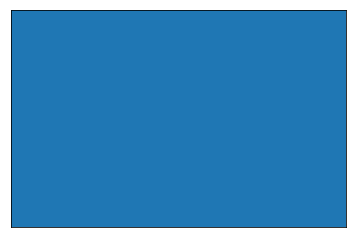

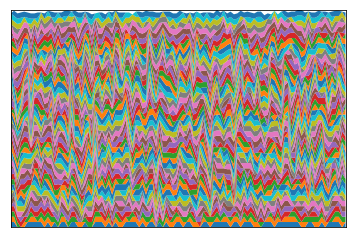

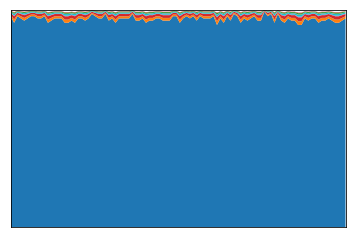

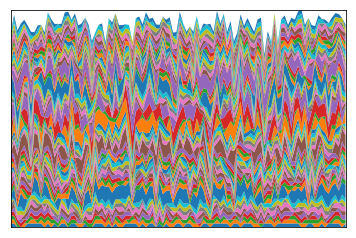

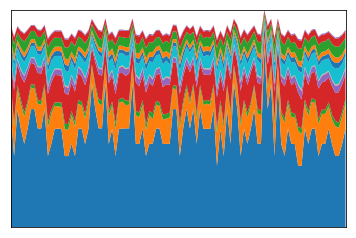

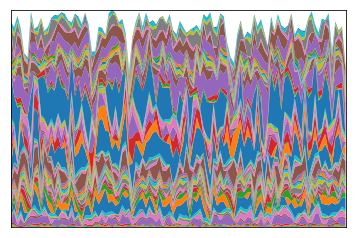

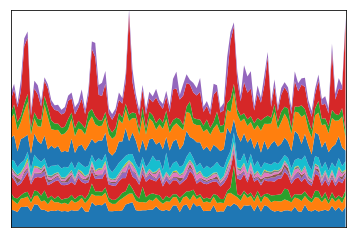

In [10]:
fig,ax=plt.subplots()
StackPlot(MyPlate.N,ax=ax,unique_color=False,drop_zero=False)
plt.show()
fig,ax=plt.subplots()
StackPlot(MyPlate.R,ax=ax,unique_color=False,drop_zero=False)
plt.show()

MyPlate.Propagate(0.01)
fig,ax=plt.subplots()
StackPlot(MyPlate.N,ax=ax,unique_color=False,drop_zero=False)
plt.show()
fig,ax=plt.subplots()
StackPlot(MyPlate.R,ax=ax,unique_color=False,drop_zero=False)
plt.show()

MyPlate.Propagate(0.1)
fig,ax=plt.subplots()
StackPlot(MyPlate.N,ax=ax,unique_color=False,drop_zero=False)
plt.show()
fig,ax=plt.subplots()
StackPlot(MyPlate.R,ax=ax,unique_color=False,drop_zero=False)
plt.show()

MyPlate.Propagate(1)
fig,ax=plt.subplots()
StackPlot(MyPlate.N,ax=ax,unique_color=False,drop_zero=False)
plt.show()
fig,ax=plt.subplots()
StackPlot(MyPlate.R,ax=ax,unique_color=False,drop_zero=False)
plt.show()

# Passaging

To illustrate the capabilities of the `Passage` method, this section replicates the results of [MS Datta <i>et al.</i>, PNAS 110:7354 (2013)](https://www.pnas.org/content/pnas/110/18/7354.full.pdf) on cooperation under range expansion. 

The authors simulate range expansion through a daily dilution protocol in 96-well plates. Every day, a fraction $f_0 (1-m)$ of the contents of each well is transferred to the corresponding well in the next row, while a fraction $f_0 m$ is transferred to the nearest neighbors in the next row. This protocol is encoded in the following transfer matrix, with $m=0.5$ and $f_0 = 1/600$, which were the parameters actually used in the experiment:

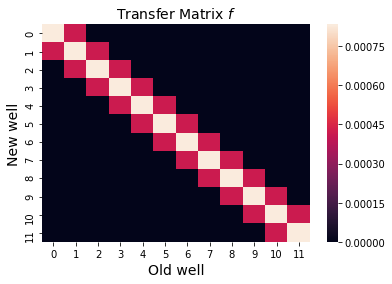

In [11]:
L = 12
f0 = 1/600
m = 0.5
f = f0*((m/2)*(np.diag(np.ones(L-1),-1)+np.diag(np.ones(L-1),1))+(1-m)*np.diag(np.ones(L)))

fig,ax=plt.subplots()
sns.heatmap(f,ax=ax)
ax.set_xlabel('Old well',fontsize=14)
ax.set_ylabel('New well',fontsize=14)
ax.set_title(r'Transfer Matrix $f$',fontsize=14)
plt.show()

They initialize the experiment with a mixture of two genetically engineered yeast strains. The "cooperator" strain (species 1) can convert sucrose (resource 1) to a mixture of glucose and fructose (resource 2). It maintains some weak ability to preferentially access the glucose and fructose it produces, but loses 99 percent of it to the surrounding solution. The "defector" strain (species 2) can consume the glucose and fructose, but cannot degrade sucrose. 

We can model this system as follows. Species 1 can "consume" both resources at rates $c_{11}, c_{12}$, respectively. But resource 1 is assigned a leakage fraction $l_1 = 0.99$, so it loses 99 percent of the incoming resource as byproducts. We choose the corresponding column of the $D$ matrix to have $D_{11} =0, D_{21} = 1$, so all of the lost resource is in the form of resource 2. Resource 2, on the other hand, has no leakage ($l_2 = 0$), and its column in the $D$ matrix is irrelevant. Species 2 cannot consume resource 1 ($c_{21} = 0$), and is a slightly better consumer of resource 2 ($c_{22} > c_{12}$). 

In [12]:
#Construct matrices 
c = np.asarray([[1,0.9],
                [0,1.1]])*0.0007
D = np.asarray([[0,0],
                [1,1]])

#Make parameter list
params = {'c':c,
          'D':D,
          'm':0,
          'w':1,
          'g':1,
          'l':[0.99,0],
          'R0':0,
          'tau':1
          }

We want to run this as a batch culture, so the intrinsic resource resupply term should be turned off:

In [13]:
assumptions = {
              'regulation':'independent',
              'supply':'off',
              'response':'type I'
             }

#Construct dynamics
def dNdt(N,R,params):
    return MakeConsumerDynamics(assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(assumptions)(N,R,params)
dynamics_range = [dNdt,dRdt]

Now let's initialize the first six wells on a row of the plate with equal concentrations of the two strains. We'll perform daily dilutions at a 1/600 dilution fraction for thirty days with no mixing or range expansion to find the steady-state bulk coexistence fraction. The fresh wells are always initialized with the same concentration of resource 1 (sucrose) and no resource 2. Blue is species 1 (cooperator) and orange is species 2 (defector). We have chosen the parameters to reflect the experiment, where most of the population are defectors, with a small fraction of cooperators:

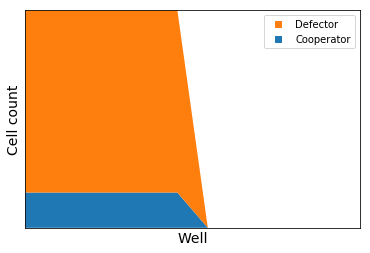

In [14]:
#Make initial state
N0 = np.zeros((2,L))
N0[:,:6] = 1
R0 = np.zeros((2,L))
R0[0,:] = 10000
init_state = [N0,R0]

#Initialize plate
range_expand = Community(init_state,dynamics_range,params,parallel=False)

#Perform daily dilutions (24 hours) for thirty days
range_expand.Propagate(24)
range_expand.RunExperiment(np.eye(12)/600,24,30,refresh_resource=True)

#Plot
fig,ax=plt.subplots()
StackPlot(range_expand.N,ax=ax)
ax.plot([],[],'s',color=colors[1],label='Defector')
ax.plot([],[],'s',color=colors[0],label='Cooperator')
plt.legend()
ax.set_xlabel('Well',fontsize=14)
ax.set_ylabel('Cell count',fontsize=14)
plt.show()

Now we perform the range expansion for 12 24-hour days, using the stepping-stone matrix $f$ we defined earlier:

In [15]:
Ntraj,Rtraj = range_expand.RunExperiment(f,24,12,refresh_resource=True)

Finally, we can plot the results, looking at both total cell density (as in Figure 2A) and cooperator fraction (as in Figure 3C):

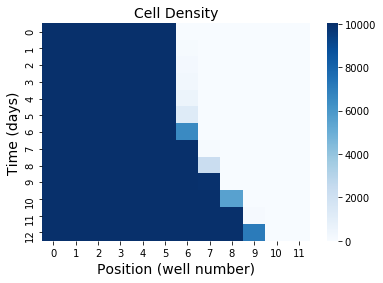

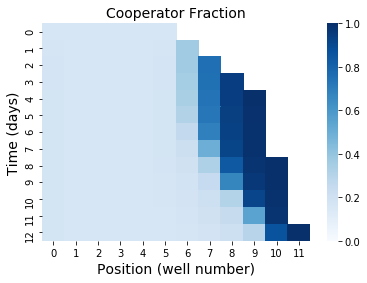

In [16]:
fig,ax=plt.subplots()
traj=Ntraj.sum(axis=1).values.reshape(13,12)
sns.heatmap(traj,cmap='Blues',ax=ax)
ax.set_xlabel('Position (well number)',fontsize=14)
ax.set_ylabel('Time (days)',fontsize=14)
ax.set_title('Cell Density',fontsize=14)
plt.show()

fig,ax=plt.subplots()
traj=(Ntraj['S0']/Ntraj.sum(axis=1)).values.reshape(13,12)
sns.heatmap(traj,cmap='Blues',vmin=0,vmax=1,ax=ax)
ax.set_xlabel('Position (well number)',fontsize=14)
ax.set_ylabel('Time (days)',fontsize=14)
ax.set_title('Cooperator Fraction',fontsize=14)
plt.show()

# Using custom dynamics

While the built-in Microbial Consumer Resource Model incorporates many of the most common choices for niche-based modeling, it does make several restrictive assumptions, in particular about the substitutability of different resource types. Some applications may therefore require the use of custom dynamics. Here, we provide an example of competition for essential resources modeled by Liebig's Law of the Minimum:

\begin{align}
\frac{dN_i}{dt} &= N_i\left(\underset{\beta}{\rm min}\left\{\frac{r_i R_\beta}{K_{i\beta}+ R_\beta}\right\} - m_i\right)\\
\frac{dR_\alpha}{dt} &= D_\alpha(s_\alpha - R_\alpha) - \sum_j  c_{j\alpha} N_j \underset{\beta}{\rm min}\left\{\frac{r_j R_\beta}{K_{i\beta}+ R_\beta}\right\} 
\end{align}

where we have employed the notation of [Huisman and Weissing (2001)](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1890/0012-9658%282001%29082%5B2682%3ABCFOAC%5D2.0.CO%3B2). We use the criterion given there for the emergence of chaotic dynamics to choose our parameters, and the resulting trajectory indeed appears to be chaotic.

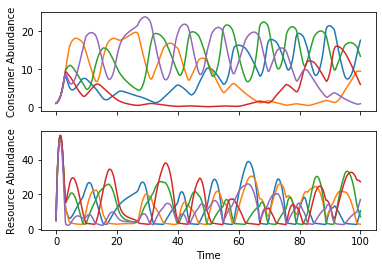

In [24]:
def sigma(R,params):
    return (np.ones(np.shape(['K'])).T*params['r']).T*R/(params['K']+np.ones(np.shape(['K']))*R)
def dNdt(N,R,params):
    #Version with soft minimum:
    #return N*((sigma(R,params)**params['alpha']).sum(axis=1)**(1/params['alpha'])-params['m'])
    return N*(np.min(sigma(R,params),axis=1)-params['m'])
def dRdt(N,R,params):
    #Version with soft minimum:
    #return (params['s']-R)*params['D'] - params['c'].T.dot(N*((sigma(R,params)**params['alpha']).sum(axis=1)**(1/params['alpha'])))
    return (params['s']-R)*params['D'] - params['c'].T.dot(N*np.min(sigma(R,params),axis=1))
dynamics = [dNdt,dRdt]
dimensions = {'SxM':['K','c'],
              'S':['r','m'],
              'M':['s','D']}

params = {'r':np.ones(5)*2,
          'm':np.ones(5),
          'D':np.ones(5),
          's':np.ones(5)*100,
          'K':np.asarray([[1,2,3,4,5],
                         [2,3,4,5,1],
                         [3,4,5,1,2],
                         [4,5,1,2,3],
                         [5,1,2,3,4]]),
          'c':np.asarray([[1,2,3,2,1],
                         [2,3,2,1,2],
                         [3,2,1,1,2],
                         [2,1,1,2,3],
                         [1,1,2,3,2]]),
         'alpha':-3}

init_state = [np.ones(5),np.ones(5)*5]
#(parallel=False ensures that tutorial will run on Windows.
#If you are running on Mac or Linux, set parallel=True to speed up)
MyPlate = Community(init_state,dynamics,params,dimensions=dimensions,parallel=False)
t, Ntraj, Rtraj = MyPlate.TestWell(T=100,ns=5000)

Now we can make three parallel wells, with almost identical initial conditions, with 5 percent random noise added to the initial consumer abundances. If the dynamics are chaotic, we will be able to see them start to do different things:

-------------Initial Transient--------------


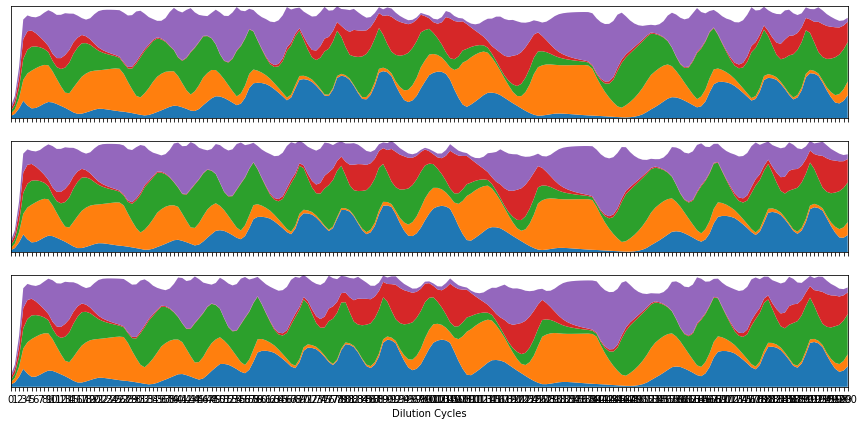

-------------2,000 time steps later--------------


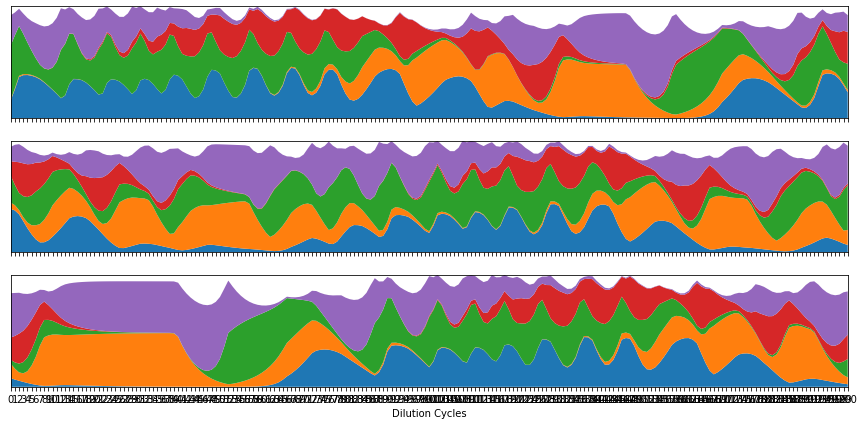

In [28]:
n_wells = 3
init_state = [np.ones((5,n_wells))+np.random.rand(5,n_wells)*0.05,np.ones((5,n_wells))*5]
#(parallel=False ensures that tutorial will run on Windows.
#If you are running on Mac or Linux, set parallel=True to speed up)
MyPlate = Community(init_state,dynamics,params,dimensions=dimensions,parallel=False)
Ntraj,Rtraj = MyPlate.RunExperiment(np.eye(n_wells),1,200,refresh_resource=False)
print('-------------Initial Transient--------------')
PlotTraj(Ntraj,figsize=(15,7))
plt.show()
Ntraj,Rtraj = MyPlate.RunExperiment(np.eye(n_wells),10,200,refresh_resource=False)
print('-------------2,000 time steps later--------------')
Ntraj,Rtraj = MyPlate.RunExperiment(np.eye(n_wells),1,200,refresh_resource=False)
PlotTraj(Ntraj,figsize=(15,7))
plt.show()

# Compare integration and EM algorithm

This is a simple script for comparing the steady states given by the EM algorithm (`SteadyState`) and direct integration of the differential equations. 

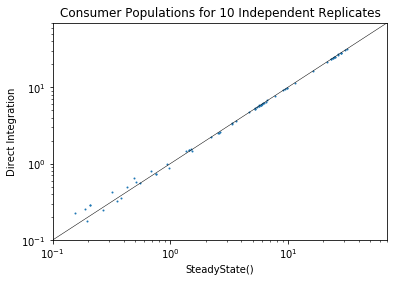

In [6]:
assumptions = a_default.copy()
assumptions.update({'SA':20*np.ones(3),
                    'MA':5*np.ones(3),
                    'Sgen':1,
                    'muc':2,
                    'R0_food':80,
                    'n_wells':10,
                    'food':0,
                    'S':40,
                    'l':0.8,
                    'supply':'external'})

init_state = MakeInitialState(assumptions)
params = MakeParams(assumptions)
def dNdt(N,R,params):
    return MakeConsumerDynamics(assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

#(parallel=False ensures that tutorial will run on Windows.
#If you are running on Mac or Linux, set parallel=True to speed up)
Plate1 = Community(init_state,dynamics,params,parallel=False)
Plate2 = Community(init_state,dynamics,params,parallel=False)
Plate1.SteadyState()
Plate2.RunExperiment(np.eye(assumptions['n_wells']),10,200)

fig,ax=plt.subplots()
ax.scatter(Plate1.N.values.reshape(-1)+1e-10,Plate2.N.values.reshape(-1)+1e-10,s=1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim((0.1,70))
ax.set_ylim((0.1,70))
ax.set_xlabel('SteadyState()')
ax.set_ylabel('Direct Integration')
ax.set_title('Consumer Populations for '+str(assumptions['n_wells'])+' Independent Replicates')
ax.plot([0.1,70],[0.1,70],'k',lw=0.5)
plt.show()

# Investigate multistability

The Microbial Consumer Resource Model can become bistable when the externally supplied resources are insufficient to support growth of any consumer species, but when a stable community can be supported on the metabolic byproducts. The easiest way to create this situation is to give the externally supplied resources $l_\alpha \approx 1$. This is actually a reasonable model for organisms that secrete enzymes to break down compounds externally, since they do not directly harvest any energy from these resources, but only from the products of the enzymatic reaction.

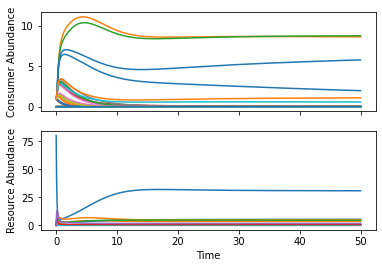

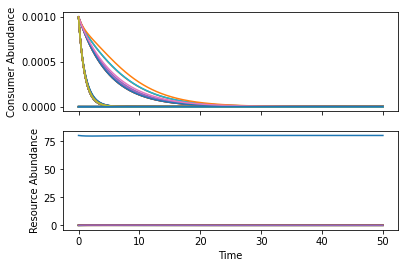

In [39]:
assumptions = a_default.copy()
assumptions.update({'SA':20*np.ones(3),
                    'MA':5*np.ones(3),
                    'Sgen':1,
                    'muc':2,
                    'R0_food':80,
                    'n_wells':3,
                    'food':0,
                    'S':40,
                    'l':0.8,
                    'supply':'external'})

init_state = MakeInitialState(assumptions)
params = MakeParams(assumptions)
params['l'] = np.random.choice([0,1],size=len(init_state[1]))*0.99
params['l'][0] = 0.99
params['R0'] = params['R0']+1e-2
def dNdt(N,R,params):
    return MakeConsumerDynamics(assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

#(parallel=False ensures that tutorial will run on Windows.
#If you are running on Mac or Linux, set parallel=True to speed up)
MyPlate = Community(init_state,dynamics,params,parallel=False)
t, Ntraj, Rtraj = MyPlate.TestWell(T=50,ns=5000)
R1 = Rtraj[-1]
MyPlate.N = init_state[0]*1e-3
t, Ntraj, Rtraj = MyPlate.TestWell(T=50,ns=5000)
R2 = Rtraj[-1]

If we start at the default initial condition for SteadyState(), we find the non-extinct state:

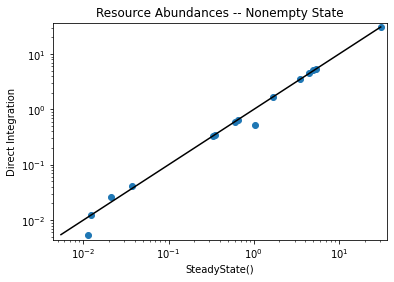

In [40]:
MyPlate.SteadyState()
plt.scatter(MyPlate.R['W0'].values,R1)
plt.plot([np.min(R1),np.max(R1)],[np.min(R1),np.max(R1)],'k')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel('SteadyState()')
plt.gca().set_ylabel('Direct Integration')
plt.gca().set_xlim((np.min(R1)*.8,np.max(R1)*1.2))
plt.gca().set_ylim((np.min(R1)*.8,np.max(R1)*1.2))
plt.gca().set_title('Resource Abundances -- Nonempty State')
plt.show()

In [41]:
MyPlate.N['W0'].sort_values(ascending=False)

F0  S2     8.700434
    S1     8.464224
F1  S20    7.215363
F2  S51    1.131751
F1  S39    0.541212
             ...   
F2  S53    0.000000
    S54    0.000000
    S55    0.000000
    S57    0.000000
F1  S30    0.000000
Name: W0, Length: 61, dtype: float64

But if we start near the fixed point of the intrinsic resource dynamics, we find the empty state:

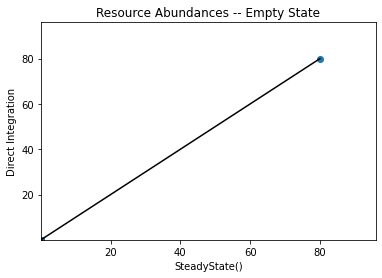

In [42]:
b = 0.01 #Average shift of R0t from R0
MyPlate.SteadyState(R0t_0 = params['R0']+np.random.rand(len(params['R0']))*2*b)
plt.scatter(MyPlate.R['W0'].values,R2)
plt.plot([np.min(MyPlate.R['W0'].values),np.max(MyPlate.R['W0'].values)],[np.min(MyPlate.R['W0'].values),np.max(MyPlate.R['W0'].values)],'k')
#plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')
plt.gca().set_xlabel('SteadyState()')
plt.gca().set_ylabel('Direct Integration')
plt.gca().set_xlim((np.min(MyPlate.R['W0'].values)*.8,np.max(MyPlate.R['W0'].values)*1.2))
plt.gca().set_ylim((np.min(MyPlate.R['W0'].values)*.8,np.max(MyPlate.R['W0'].values)*1.2))
plt.gca().set_title('Resource Abundances -- Empty State')
plt.show()

In [43]:
MyPlate.N['W0'].sort_values(ascending=False)

F2  S56    6.715218e-10
    S44    6.369134e-10
F1  S39    6.366464e-10
F2  S51    6.361041e-10
F0  S14    6.357061e-10
               ...     
F2  S53    0.000000e+00
    S54    0.000000e+00
    S55    0.000000e+00
    S57    0.000000e+00
F1  S30    0.000000e+00
Name: W0, Length: 61, dtype: float64